In [1]:
%pylab inline
import tensorflow as tf
import sys
sys.path.insert(0, '../python')

Populating the interactive namespace from numpy and matplotlib


# Step I: Reading data

In [2]:
from DeepDeconv.utils.batch_utils import dynamic_batches

In [3]:
#Input the directory containing the fits file
data_directory = '/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/'
write_path="/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/"

#Retrieves the list of all the files
import glob

gal_files = glob.glob(data_directory+'image-*-multihdu.fits')
gal_files.sort()

SNR = [20,100]#Range of SNR simulated
noiseless_img_hdu = 0
psf_hdu = 1
targets_hdu = 2
deconv_mode = 'TIKHONOV'

In [4]:
gen = dynamic_batches(gal_files[2:] , batch_size=16, noise_std=None, SNR=SNR, 
                noiseless_img_hdu=noiseless_img_hdu, targets_hdu=targets_hdu,
                psf_hdu=psf_hdu, image_dim=96, image_per_row=100,
                deconv_mode=deconv_mode)

In [5]:
a = next(gen)

IndexError: list index out of range

In [ ]:
a[0].shape, a[1].shape, a[2].shape

In [ ]:
subplot(121)
imshow(a[0][3,:,:,0])
subplot(122)
imshow(a[1][3,:,:,0])

## Step II: Define a network

In [7]:
# Disclaimer.... this is a very stupid network
inputs = tf.keras.Input(shape=[96, 96, 1])

net = tf.keras.layers.Conv2D(32, 3, padding='same')(inputs)
net = tf.keras.layers.Activation('relu')(net)
net = tf.keras.layers.Conv2D(16, 3, padding='same')(net)

outputs = tf.keras.layers.Conv2D(1, 3, padding='same')(net)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [8]:
# Define custom loss and metric for a multi window (shearlets) shape constraint
# Define constants required for the custom functions
from DeepDeconv.deepnetFCS.DeepNet import makeUi
from AlphaTransform import AlphaShearletTransform as AST
import shape_constraint.cadmos_lib as cl

img_rows=img_cols=96
gamma = 1

# Generate the adjoints of shearlets applied to U
U = cl.makeUi(img_rows,img_cols)
#Step 1 : create a shearlet transform instance
trafo = AST(img_cols, img_rows, [0.5]*3,real=True,parseval=True,verbose=False)
#Step 2 : get shearlets filters
shearlets = trafo.shearlets
#Step 3 : get the adjoints
adjoints = cl.get_adjoint_coeff(trafo)
#Normalize shearlets filter banks
#/!\ The order is important/!\
adjoints = cl.shear_norm(adjoints,shearlets)
shearlets = cl.shear_norm(shearlets,shearlets)
#Compute moments constraint normalization coefficients
#the $\Psi^*_j$ are noted adj_U
adj_U = cl.comp_adj(U,adjoints).reshape(6,27,1,96,96,1)
mu = cl.comp_mu(adj_U)

def custom_loss(y_true,y_pred):
    residual=y_pred-y_true
    data_fid = tf.keras.backend.mean(tf.keras.backend.square(y_true-y_pred), axis=-1)
    shape_constraint=0
    for i in range(6):
        for j in range(27):
            shape_constraint+=mu[i,j]*\
            tf.keras.backend.square(
                tf.keras.backend.sum(residual*adj_U[i,j],axis=(1,2,3)))
    shape_constraint=shape_constraint*gamma/(img_rows*img_cols)
    shape_constraint=tf.keras.backend.expand_dims((tf.keras.backend.expand_dims(shape_constraint, axis=-1)),axis=-1)
    loss=data_fid+shape_constraint
    return loss
    
def custom_metric(y_true,y_pred):
    residual=y_pred-y_true
    shape_constraint=0
    for i in range(6):
        for j in range(27):
            shape_constraint+=mu[i,j]*\
            tf.keras.backend.square(
                tf.keras.backend.sum(residual*adj_U[i,j],axis=(1,2,3)))
    shape_constraint=shape_constraint*gamma/(img_rows*img_cols)
    shape_constraint=tf.keras.backend.expand_dims((tf.keras.backend.expand_dims(shape_constraint, axis=-1)),axis=-1)    
    return shape_constraint

Using TensorFlow backend.
../python/shape_constraint/cadmos_lib.py:149: ComplexWarning: Casting complex values to real discards the imaginary part
  coeff[s] = trafo.adjoint_transform(temp, do_norm=False)


In [10]:
# Compile the model
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer = tf.keras.optimizers.Adam(lr=1e-3), loss = custom_loss, weighted_metrics=[tf.keras.metrics.mse,custom_metric])

## Step III: Training

In [11]:
# Train the model
history = model.fit_generator(gen, 
                              steps_per_epoch=100,
                              epochs=20)

Epoch 1/20
100/100 [==============================] - 26s 258ms/step - loss: 0.2376 - weighted_mean_squared_error: 3.3664e-04 - weighted_custom_metric: 2.8102e-07
Epoch 2/20
100/100 [==============================] - 8s 84ms/step - loss: 0.1570 - weighted_mean_squared_error: 2.3499e-04 - weighted_custom_metric: 3.2002e-08
Epoch 3/20
100/100 [==============================] - 8s 79ms/step - loss: 0.1666 - weighted_mean_squared_error: 2.2147e-04 - weighted_custom_metric: 3.9353e-08
Epoch 4/20
100/100 [==============================] - 8s 81ms/step - loss: 0.1519 - weighted_mean_squared_error: 2.1318e-04 - weighted_custom_metric: 3.9540e-08
Epoch 5/20
100/100 [==============================] - 8s 79ms/step - loss: 0.1536 - weighted_mean_squared_error: 2.1842e-04 - weighted_custom_metric: 5.3996e-08
Epoch 6/20
100/100 [==============================] - 8s 81ms/step - loss: 0.1497 - weighted_mean_squared_error: 2.1990e-04 - weighted_custom_metric: 3.2941e-08
Epoch 7/20
100/100 [============

dict_keys(['loss', 'weighted_mean_squared_error', 'weighted_custom_metric'])


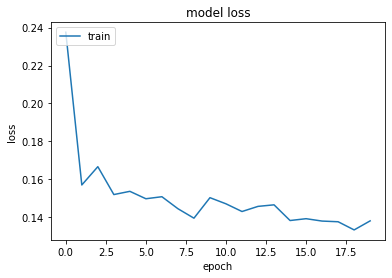

In [12]:
# have a look at history
history
# list all data in history
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

## Step IV: Applying the model

In [13]:
# The model can be applied like so:
res = model(a[0].astype('float32'))
# This should return the solution of the deconvolution prblm
res_np = tf.keras.backend.eval(res).squeeze(axis=-1) #convert solution to numpy array and remove last dimension

Text(0.5, 1.0, 'Deconvolved')

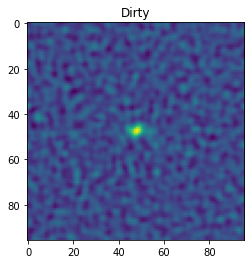

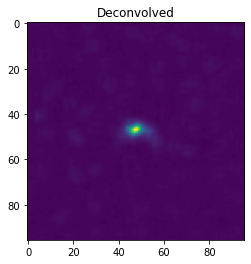

In [14]:
# Show a deconvolved image
figure()
imshow(a[0][0].squeeze(axis=-1))
title('Dirty')
figure()
imshow(res_np[0])
title('Deconvolved')